In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod

/Users/huseyin/miniforge3/envs/tf-env/lib/python3.8/site-packages/art/estimators/certification/__init__.py:13: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_test = x_test[0:100]
y_test = y_test[0:100]

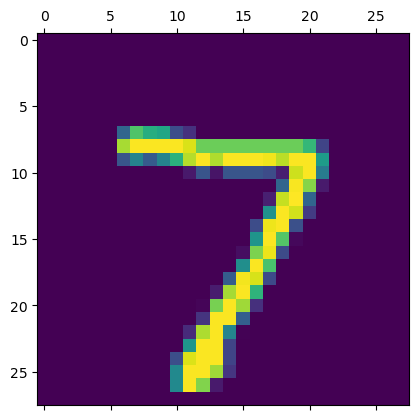

In [3]:
plt.matshow(x_test[0])
plt.show()

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']);

In [5]:
model.fit(x_train, y_train, epochs=3);

Train on 60000 samples
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/3


2022-12-26 22:08:08.397518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-26 22:08:08.397835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-26 22:08:08.403560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-26 22:08:08.410638: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-26 22:08:08.414977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:08.449539: I tensorflow/core/grappler/optimizers/custom_graph

60000/60000 [==============================] - 12s 206us/sample - loss: 0.2859 - accuracy: 0.9173
Epoch 2/3
60000/60000 [==============================] - 11s 190us/sample - loss: 0.1348 - accuracy: 0.9593
Epoch 3/3
60000/60000 [==============================] - 12s 192us/sample - loss: 0.1006 - accuracy: 0.9696


In [6]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 99.00%


/Users/huseyin/miniforge3/envs/tf-env/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-12-26 22:08:43.817412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


model.save('model/')

In [7]:
from tensorflow.keras.models import load_model

model = load_model('model/')

2022-12-26 22:08:44.149693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:44.171256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [8]:
x_test.shape

(100, 28, 28)

In [9]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [10]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)

In [11]:
x_test_adv = attack_fgsm.generate(x_test)

/Users/huseyin/miniforge3/envs/tf-env/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-12-26 22:08:44.296326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:44.382928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

/Users/huseyin/miniforge3/envs/tf-env/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-12-26 22:08:44.548800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:44.557188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy on adversarial test data: 0.00%
Average perturbation: 0.18


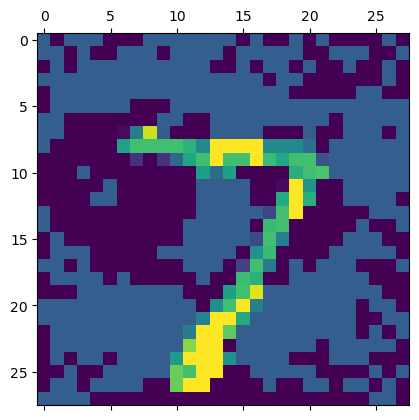

In [13]:
plt.matshow(x_test_adv[0])
plt.show()

In [14]:
attack_cw = CarliniLInfMethod(classifier=classifier,
                              max_iter=100,
                              learning_rate=0.01,
                              initial_const=1e0,
                              largest_const=2e0)

In [15]:
x_test_adv = attack_cw.generate(x_test)

C&W L_inf:   0%|          | 0/100 [00:00<?, ?it/s]

2022-12-26 22:08:44.987550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:45.326021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:48.561743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:48.694966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:52.147612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:58.443135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 22:08:58.584262: I tensorflow/core/grappler/optimizers/cust

In [16]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 26.00%
Average perturbation: 0.02


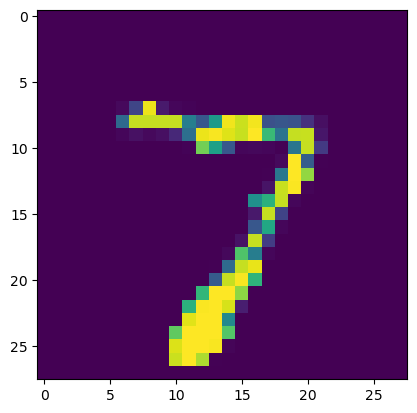

In [28]:
plt.imshow(x_test_adv[0])

plt.show()

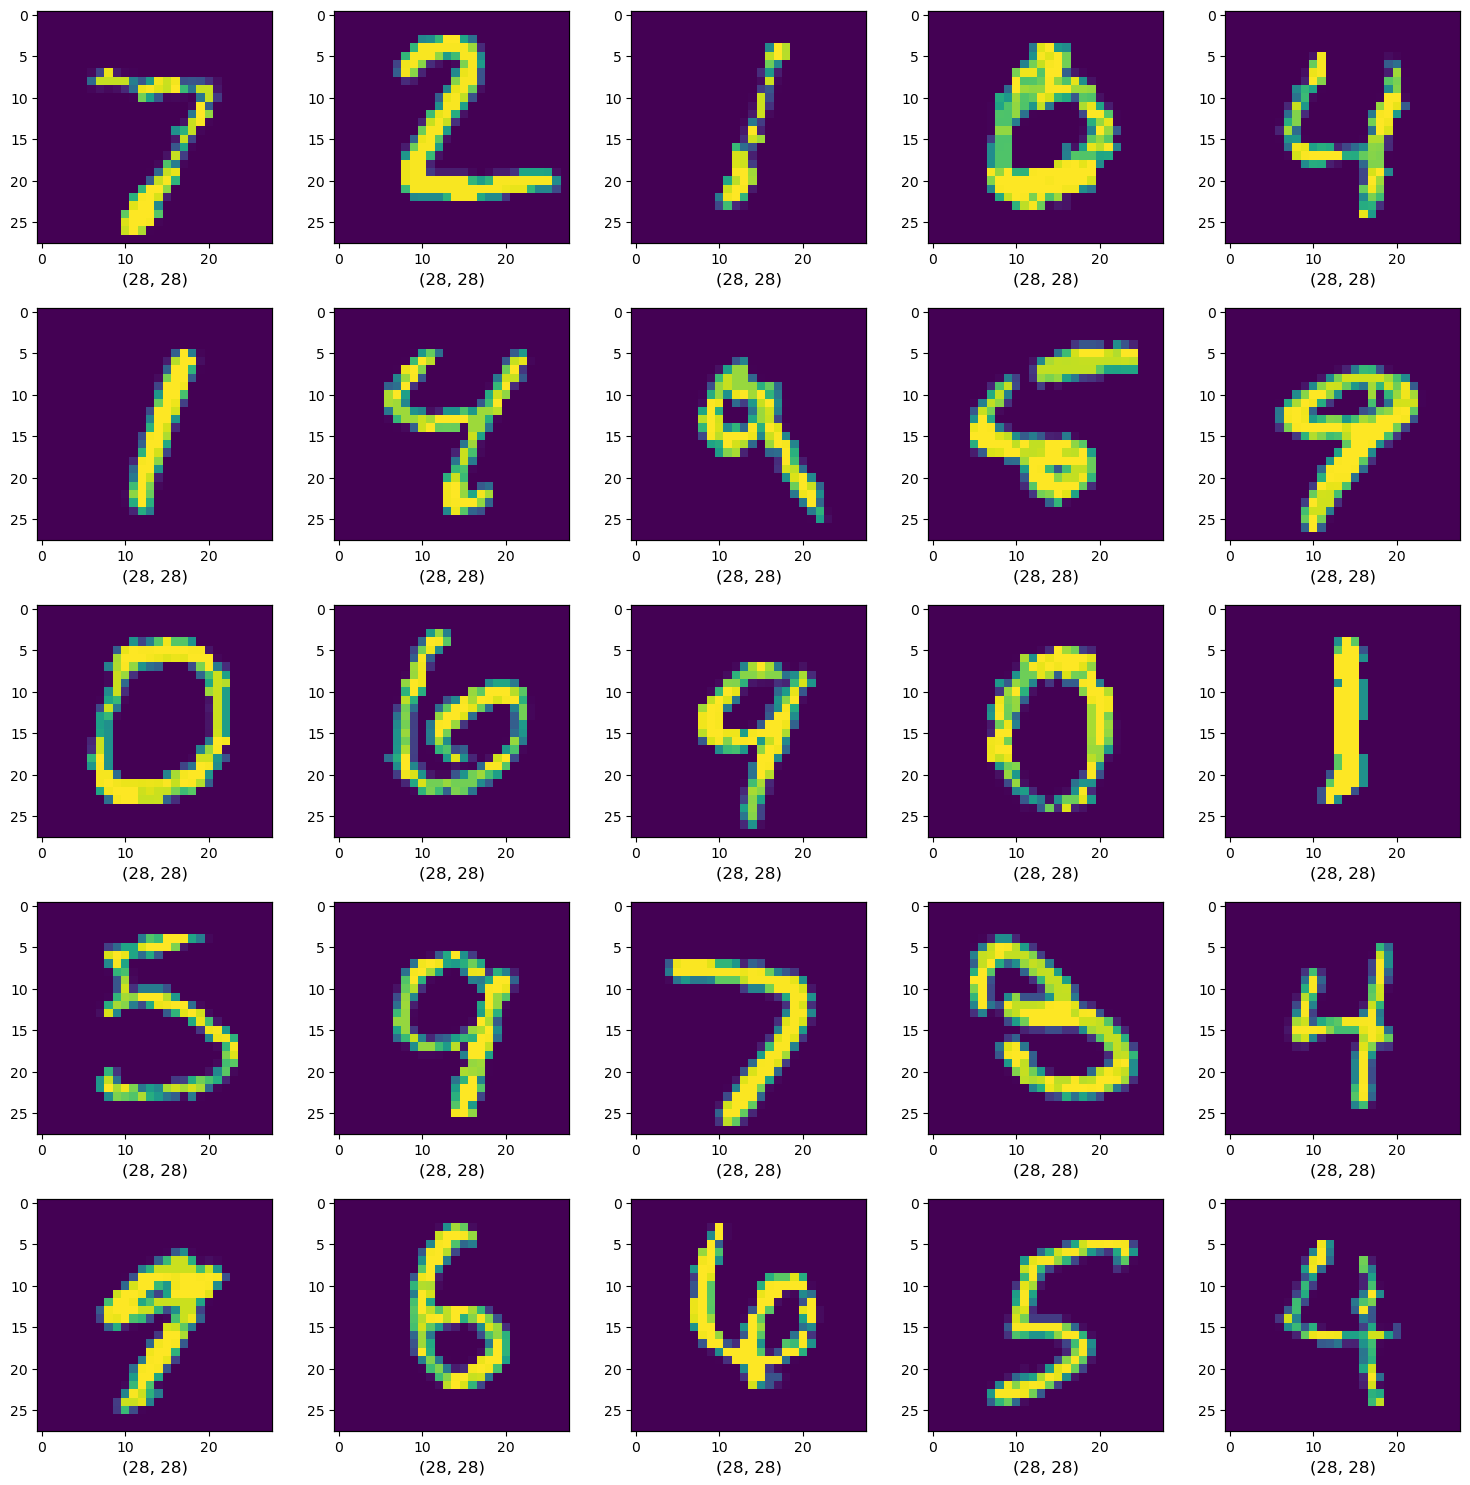

In [30]:
rows = 5
columns = 5

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    
    idx = num - 1
    
    plt.imshow(x_test_adv[idx], aspect='auto')
    plt.xlabel(f'{x_test_adv[idx].shape}', fontsize=12)
    
    
    
fig.tight_layout() # used to adjust padding between subplots 

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])